# Read in redrock output for SV1 Blanc Deep Exposures

In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-_1r5a9xk
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-_1r5a9xk
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1057822 sha256=ca495a09b21a8bcf3bb4cd00dd00b8b1e5d9803ac9e9c1cf5097da8c9aef3ab9
  Stored in directory: /tmp/pip-ephem-wheel-cache-enw4su5x/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
from bgs_sv import sv1

In [4]:
# get TileIDs of Blanc deep exposures
deep_exp = sv1.blanc_deep_exposures()

In [5]:
deep_exp

TILEID,EXPTIME,B_DEPTH,R_DEPTH,Z_DEPTH,TILERA,TILEDEC
int64,float32,float32,float32,float32,float32,float32
80605,4500.188,4306.8,3388.2,2881.5999,36.448,-4.601
80606,9900.668,9562.1,8119.6006,8060.6997,36.448,-4.501
80607,12600.787,12901.699,12195.501,12437.299,106.74,56.1
80608,18901.31,18156.197,18712.4,20961.799,106.74,56.2
80609,11700.602,11350.299,8213.101,7413.401,150.12,2.206
80610,9900.556,7230.9995,5673.0005,5441.9,150.12,2.306
80611,1800.537,599.30005,1030.6,1585.1001,35.22,30.3
80612,2700.6401,2052.3,2611.5,3207.2002,66.68,-5.24
80613,2700.722,2604.9,3270.3,4127.3,106.74,56.1


In [6]:
# get redrock zbest file for deep exposure
zbest = sv1.get_zbest(deep_exp['TILEID'][9], 'deep', targetclass='bright')

In [7]:
zbest

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,TARGET_RA,TARGET_DEC,FLUX_R,FIBERFLUX_R,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,DESI_TARGET,BGS_TARGET
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,float64,float64,float32,float32,str1,int64,int64,int64,int64
39627714830796549,8699.758542977273,519.5417256005142 .. 3.973567050913664,0.46998040523963713,0.00010169554079946927,0,7927,GALAXY,,10,345.1201138049364,0,1,153.83374311555582,-2.918718015557949,16.74688,4.9915586,S,1152921504732676217,131074,0,0
39627714830796890,8222.362058758736,634.2726683959203 .. 6.0222258843620144,0.15535415669251315,9.690354826903852e-06,0,7924,GALAXY,,10,571.3116875886917,0,1,153.8500677385002,-2.8897959874514996,69.457016,4.8695545,S,1152921504606846976,131074,0,0
39627714830798488,78411.57190588662,-23407.87256614676 .. 0.0,9.521301684159149e-05,9.540514547596102e-07,0,7928,STAR,M,5,291614.25069432904,0,1,153.9347820085281,-2.9087333147209193,24.139637,18.764397,S,1152921504724287601,655370,0,0
39627714830799406,8213.99819546938,279.7710801582137 .. 2.361403086985407,0.1801377451973022,8.196952424934093e-06,0,7882,GALAXY,,10,478.1733047366142,0,1,153.97810731977967,-2.8763995527609256,21.574492,2.368062,S,1152921504606846976,131074,0,0
39627714830799666,9746.891668915749,320.0010312461728 .. 15.592757344317615,0.22205998798163412,7.596184103271948e-06,0,7926,GALAXY,,10,3054.0358518362045,0,1,153.99196226506743,-2.917748140366553,14.996162,6.5504346,S,1152921504606846976,131074,0,0
39627714830799782,8560.63836582005,199.2860119084129 .. -18.15972152947729,0.3933271419269279,4.726638074007248e-05,0,7929,GALAXY,,10,633.2096100077033,0,1,153.99804116517242,-2.945842768445007,21.833357,5.4648433,S,1152921504715898985,131074,0,0
39627714834989881,8210.531513462774,385.0773988141269 .. -27.555139817244214,0.05988409886021427,7.914638305433795e-05,0,7927,GALAXY,,10,214.6694064117637,0,1,154.04106227588596,-2.9591653240407823,29.259287,7.2077875,S,1152921504606846976,655370,0,0
39627714834990892,8927.006113246083,340.5834578787334 .. 33.494681385957186,0.07976567899395617,8.79386001523111e-06,0,7924,GALAXY,,10,2922.3800176009536,0,1,154.0899818819509,-2.90964345444212,79.07574,16.962746,S,1152921504606846976,131074,0,0
39627714834991015,9038.271657887846,2223.72093367899 .. 130.16057868452666,0.11399530237573813,2.4994587019404475e-05,0,7929,GALAXY,,10,2624.795674271416,0,1,154.09563694019886,-2.9396988002866586,94.57778,28.793884,S,1152921504606846976,131074,0,0


In [8]:
# redshift success criteria
def zsuccess_criteria(zbest): 
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    print('%i of %i pass the redshift success criteria' % (np.sum(zsuccess), len(zsuccess)))
    print('%.2f redshift success rate' % (np.sum(zsuccess)/len(zsuccess)))
    return zsuccess

In [9]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

In [10]:
# convert r-band flux to magnitude
r_mag = 22.5 - 2.5 * np.log10(zbest['FLUX_R'])

In [11]:
r_mid, zs, zs_err = zsuccess_rate(r_mag, zsuccess_criteria(zbest))

952 of 987 pass the redshift success criteria
0.96 redshift success rate


Text(0, 0.5, '$z$ success rate')

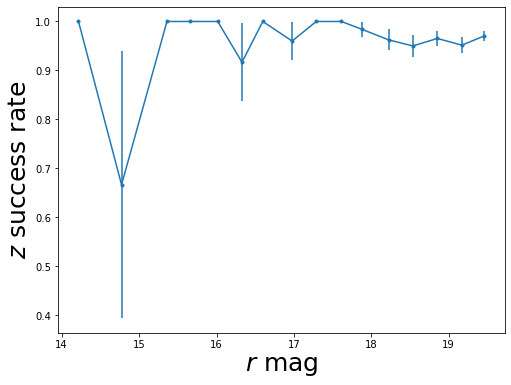

In [12]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs)
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_ylabel('$z$ success rate', fontsize=25)

974 of 1018 pass the redshift success criteria
0.96 redshift success rate
tileid = 80611

1068 of 1102 pass the redshift success criteria
0.97 redshift success rate
tileid = 80612

961 of 1116 pass the redshift success criteria
0.86 redshift success rate
tileid = 80613

952 of 987 pass the redshift success criteria
0.96 redshift success rate
tileid = 80614

1074 of 1143 pass the redshift success criteria
0.94 redshift success rate
tileid = 80616

977 of 1012 pass the redshift success criteria
0.97 redshift success rate
tileid = 80617

967 of 1053 pass the redshift success criteria
0.92 redshift success rate
tileid = 80618

903 of 969 pass the redshift success criteria
0.93 redshift success rate
tileid = 80619



Text(0, 0.5, '$z$ success rate')

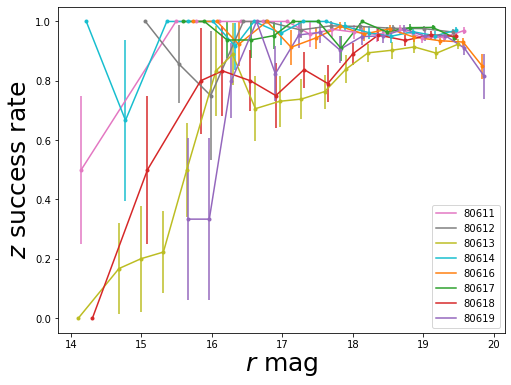

In [13]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

for i, tileid in enumerate(deep_exp['TILEID']):
    try: 
        zbest = sv1.get_zbest(tileid, 'deep', targetclass='bright')
    except: 
        continue
    if len(zbest) < 200: continue 
    # convert r-band flux to magnitude
    r_mag = 22.5 - 2.5 * np.log10(zbest['FLUX_R'])
    r_mid, zs, zs_err = zsuccess_rate(r_mag, zsuccess_criteria(zbest))
    print('tileid = %i' % tileid)
    sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C%i' % (i % 10))
    sub.plot(r_mid, zs, c='C%i' % (i % 10), label=str(tileid))
    print()
sub.legend(loc='lower right')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_ylabel('$z$ success rate', fontsize=25)

# Why do TILEID=80613 and 80618 have < 90% redshift success rate?

In [14]:
all_exps = sv1.blanc_nexp1_exposures()

In [15]:
all_exps[all_exps['TILEID'] == 80613]

NIGHT,EXPID,TILEID,TILERA,TILEDEC,EXPTIME,MJDOBS,FIELD,TARGETS,EBV,SPECMODEL_SKY_RMAG_AB,NGFA,B_DEPTH,R_DEPTH,Z_DEPTH,TGT,SKY,STD,WD,LRG,ELG,QSO,BGS,MWS,GFA_AIRMASS_MIN,GFA_AIRMASS_MEAN,GFA_AIRMASS_MED,GFA_AIRMASS_MAX,GFA_MOON_ILLUMINATION_MIN,GFA_MOON_ILLUMINATION_MEAN,GFA_MOON_ILLUMINATION_MED,GFA_MOON_ILLUMINATION_MAX,GFA_MOON_ZD_DEG_MIN,GFA_MOON_ZD_DEG_MEAN,GFA_MOON_ZD_DEG_MED,GFA_MOON_ZD_DEG_MAX,GFA_MOON_SEP_DEG_MIN,GFA_MOON_SEP_DEG_MEAN,GFA_MOON_SEP_DEG_MED,GFA_MOON_SEP_DEG_MAX,GFA_TRANSPARENCY_MIN,GFA_TRANSPARENCY_MEAN,GFA_TRANSPARENCY_MED,GFA_TRANSPARENCY_MAX,GFA_FWHM_ASEC_MIN,GFA_FWHM_ASEC_MEAN,GFA_FWHM_ASEC_MED,GFA_FWHM_ASEC_MAX,GFA_SKY_MAG_AB_MIN,GFA_SKY_MAG_AB_MEAN,GFA_SKY_MAG_AB_MED,GFA_SKY_MAG_AB_MAX,GFA_FIBER_FRACFLUX_MIN,GFA_FIBER_FRACFLUX_MEAN,GFA_FIBER_FRACFLUX_MED,GFA_FIBER_FRACFLUX_MAX,GFA_FIBER_FRACFLUX_ELG_MIN,GFA_FIBER_FRACFLUX_ELG_MEAN,GFA_FIBER_FRACFLUX_ELG_MED,GFA_FIBER_FRACFLUX_ELG_MAX,GFA_TRANSPFRAC_MIN,GFA_TRANSPFRAC_MEAN,GFA_TRANSPFRAC_MED,GFA_TRANSPFRAC_MAX
int64,int64,int64,float32,float32,float32,float32,bytes30,bytes8,float32,float32,int64,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
20201218,68657,80613,106.74,56.1,300.086,59202.25,Lynx,BGS+MWS,0.05,21.809383,50,689.4,690.8,749.4,4199,800,150,12,519,24,12,3279,919,1.2270021,1.2334998,1.2334447,1.2410351,0.2417941,0.24202976,0.24203044,0.2422374,105.1657,105.96203,105.96415,106.664345,129.81216,129.81715,129.81725,129.81729,0.9722683,0.98621505,0.98658144,1.0011024,0.75959784,0.8036143,0.79898494,0.85769683,21.488312,20.973072,20.979303,20.83012,0.67865807,0.71932375,0.7201219,0.7422267,0.481408,0.50569755,0.50659025,0.52072453,0.67707556,0.70939714,0.70897204,0.7374695
20201218,68658,80613,106.74,56.1,300.1,59202.258,Lynx,BGS+MWS,0.05,21.788887,50,641.3,630.4,661.6,4199,800,150,12,519,24,12,3279,919,1.208852,1.2147998,1.2147421,1.2218245,0.24240805,0.24264804,0.24264891,0.24285597,107.15443,107.967995,107.97086,108.673256,129.74391,129.7487,129.74881,129.74886,0.9739346,0.98589534,0.9855401,0.997213,0.79939777,0.8362923,0.83620924,0.8783309,21.532959,20.984539,20.997179,20.84544,0.6598241,0.6970888,0.69746333,0.7274318,0.46798083,0.49219447,0.49310136,0.5111994,0.6520518,0.68724215,0.6898897,0.70870006
20201218,68659,80613,106.74,56.1,300.087,59202.266,Lynx,BGS+MWS,0.05,21.75926,50,574.8,549.7,555.3,4199,800,150,12,519,24,12,3279,919,1.1922752,1.1977028,1.1976471,1.2041165,0.24302694,0.24326715,0.2432681,0.2434753,109.16583,109.98257,109.98569,110.69083,129.67535,129.68022,129.68033,129.68037,0.9718642,0.9830243,0.98333406,0.9954047,0.83760667,0.87907845,0.87635463,0.9332122,21.496902,20.898024,20.912832,20.722706,0.62000173,0.665292,0.6654614,0.6974537,0.4445429,0.4727831,0.47256762,0.49278066,0.6097285,0.65399736,0.6559991,0.6804807
20201221,69225,80613,106.74,56.1,300.086,59205.15,Lynx,BGS+MWS,0.05,20.608278,50,118.9,236.5,364.8,4199,800,150,12,519,24,12,3279,919,1.689407,1.7085348,1.7083795,1.7310137,0.5170011,0.51725864,0.51725936,0.5174823,45.53554,46.1107,46.110893,46.61642,100.001114,100.00319,100.00323,100.00329,0.9885093,1.0001675,1.0009046,1.0121459,0.7732791,0.81913257,0.8142393,0.8893057,20.34598,20.286936,20.293272,20.194124,0.6435919,0.69314003,0.69724345,0.717393,0.45800483,0.48912784,0.49149302,0.50428474,0.64592654,0.69326115,0.69923514,0.7193689
20201221,69226,80613,106.74,56.1,300.008,59205.156,Lynx,BGS+MWS,0.05,20.64815,50,105.5,212.4,335.5,4199,800,150,12,519,24,12,3279,919,1.6404428,1.6582342,1.6581068,1.6791217,0.51760536,0.5178629,0.51786345,0.5180868,46.832325,47.432045,47.43196,47.958977,99.93588,99.938286,99.93834,99.93843,0.9879061,0.9991671,0.99949867,1.0100727,0.835

In [16]:
all_exps[all_exps['TILEID'] == 80618]

NIGHT,EXPID,TILEID,TILERA,TILEDEC,EXPTIME,MJDOBS,FIELD,TARGETS,EBV,SPECMODEL_SKY_RMAG_AB,NGFA,B_DEPTH,R_DEPTH,Z_DEPTH,TGT,SKY,STD,WD,LRG,ELG,QSO,BGS,MWS,GFA_AIRMASS_MIN,GFA_AIRMASS_MEAN,GFA_AIRMASS_MED,GFA_AIRMASS_MAX,GFA_MOON_ILLUMINATION_MIN,GFA_MOON_ILLUMINATION_MEAN,GFA_MOON_ILLUMINATION_MED,GFA_MOON_ILLUMINATION_MAX,GFA_MOON_ZD_DEG_MIN,GFA_MOON_ZD_DEG_MEAN,GFA_MOON_ZD_DEG_MED,GFA_MOON_ZD_DEG_MAX,GFA_MOON_SEP_DEG_MIN,GFA_MOON_SEP_DEG_MEAN,GFA_MOON_SEP_DEG_MED,GFA_MOON_SEP_DEG_MAX,GFA_TRANSPARENCY_MIN,GFA_TRANSPARENCY_MEAN,GFA_TRANSPARENCY_MED,GFA_TRANSPARENCY_MAX,GFA_FWHM_ASEC_MIN,GFA_FWHM_ASEC_MEAN,GFA_FWHM_ASEC_MED,GFA_FWHM_ASEC_MAX,GFA_SKY_MAG_AB_MIN,GFA_SKY_MAG_AB_MEAN,GFA_SKY_MAG_AB_MED,GFA_SKY_MAG_AB_MAX,GFA_FIBER_FRACFLUX_MIN,GFA_FIBER_FRACFLUX_MEAN,GFA_FIBER_FRACFLUX_MED,GFA_FIBER_FRACFLUX_MAX,GFA_FIBER_FRACFLUX_ELG_MIN,GFA_FIBER_FRACFLUX_ELG_MEAN,GFA_FIBER_FRACFLUX_ELG_MED,GFA_FIBER_FRACFLUX_ELG_MAX,GFA_TRANSPFRAC_MIN,GFA_TRANSPFRAC_MEAN,GFA_TRANSPFRAC_MED,GFA_TRANSPFRAC_MAX
int64,int64,int64,float32,float32,float32,float32,bytes30,bytes8,float32,float32,int64,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
20201219,68837,80618,114.221,38.469,300.092,59203.227,NGC2419,BGS+MWS,0.06,21.405485,50,104.4,134.4,187.7,4199,800,172,17,477,17,16,3150,1036,1.3787302,1.3939381,1.3937984,1.4119916,0.3315653,0.33182088,0.3318216,0.3320416,86.0956,86.88217,86.884155,87.56252,130.72366,130.7284,130.72849,130.72868,0.95142764,0.9697033,0.96961683,0.9939979,1.2289239,1.5446136,1.5026076,3.1292126,21.021051,20.9312,20.949404,20.730295,0.18452652,0.37941638,0.38232422,0.4956589,0.15283738,0.30037007,0.3036773,0.37238556,0.17556363,0.3679615,0.37434176,0.47842336
20201219,68838,80618,114.221,38.469,300.004,59203.234,NGC2419,BGS+MWS,0.06,21.517515,50,132.8,151.2,189.4,4199,800,172,17,477,17,16,3150,1036,1.3227308,1.3361174,1.3359922,1.3518344,0.33245248,0.33270603,0.33270684,0.3329273,88.71473,89.502235,89.50444,90.190384,130.60733,130.61157,130.61163,130.61185,0.9349987,0.9620055,0.9619436,0.97562575,1.1066748,1.4713322,1.4531193,2.0550702,21.113993,20.981646,20.993954,20.85565,0.2328232,0.3894437,0.38809413,0.5425575,0.19781122,0.3040269,0.3041333,0.39972186,0.21768938,0.37477607,0.3732155,0.52182215
20201219,68839,80618,114.221,38.469,300.002,59203.242,NGC2419,BGS+MWS,0.06,21.616081,50,119.7,135.7,161.3,4199,800,172,17,477,17,16,3150,1036,1.2858243,1.2979615,1.2978631,1.3120799,0.33310938,0.33336002,0.33336055,0.33358064,90.67263,91.455605,91.45703,92.14577,130.52373,130.52812,130.52823,130.52878,0.9442166,0.9637285,0.9642795,0.99133503,1.0674534,1.6317458,1.5354474,2.938122,21.1101,21.033232,21.04614,20.91768,0.2017354,0.35284662,0.36108828,0.5675326,0.17352445,0.2783008,0.2849721,0.41582426,0.19523212,0.3402598,0.3492905,0.54197985
20201220,69048,80618,114.221,38.469,300.099,59204.26,NGC2419,BGS+MWS,0.06,21.388758,42,94.1,117.6,143.6,4199,800,172,17,477,17,16,3150,1036,1.180653,1.1898384,1.1897376,1.2018343,0.43126747,0.43156946,0.43157056,0.4318073,85.27722,86.20962,86.2128,86.94501,118.34237,118.34617,118.34626,118.34641,0.94189376,0.960988,0.96063083,0.97946274,1.2783165,1.5079148,1.4862304,1.8096272,21.017105,20.66552,20.672426,20.539234,0.2867531,0.3671663,0.37161618,0.45101058,0.23654047,0.28971407,0.2928675,0.34297237,0.27711076,0.3528506,0.35570577,0.43432692
20201220,69050,80618,114.221,38.469,300.011,59204.277,NGC2419,BGS+MWS,0.06,21.645699,40,157.4,164.6,185.8,4199,800,172,17,477,17,16,3150,1036,1.132576,1.1402546,1.1401972,1.1495159,0.43268624,0.43297306,0.4329733,0.43321764,89.49812,90.39206,90.39262,91.155174,118.16945,118.17346,118.17356,118.17367,0.94627464,0.9606963,0.9